In [181]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

In [182]:
df = pd.read_csv('data_ab.csv')

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [192]:
df.shape

(290584, 5)

Наша команда выбрала **конверсию** в качестве метрики, с которой мы будем работать, так как это:

Прямая бизнес-метрика - показывает, насколько эффективно лендинг превращает посетителей в конвертированных пользователей.

Бинарная переменная - удобна для статистических тестов (например, Z-тест, хи-квадрат).

Соответствует цели A/B-теста - мы хотим понять, какой вариант страницы лучше приводит к целевому действию (конверсии).

# Анализ дубликатов пользователей

Посмотрим на количество дубликатов

In [186]:
user_counts = df['user_id'].value_counts()
duplicate_users = user_counts[user_counts > 1]

print(f"Всего записей: {len(df):,}")
print(f"Уникальных пользователей: {df['user_id'].nunique():,}")
print(f"Пользователей с дубликатами: {len(duplicate_users):,}")

Всего записей: 294,478
Уникальных пользователей: 290,584
Пользователей с дубликатами: 3,894


Также заметили, что некоторые пользователи видят не ту версию страницы

In [187]:
print(pd.crosstab(df['group'], df['landing_page']))

landing_page  new_page  old_page
group                           
control           1928    145274
treatment       145311      1965


Теперь посмотрим, одни и те же ли это люди

In [188]:
mask_wrong = (
    ((df['group'] == 'control') & (df['landing_page'] == 'new_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))
)

wrong_page_df = df[mask_wrong]

wrong_users = wrong_page_df['user_id'].unique()

set_duplicate_user_ids = set(duplicate_users.index)
set_wrong_user_ids = set(wrong_users)

intersection = set_duplicate_user_ids.intersection(set_wrong_user_ids)
print(f"\nПересечение (дубликаты и неправильная страница): {len(intersection):,}")


Пересечение (дубликаты и неправильная страница): 3,893


Теперь посмотрим на одного оставшегося пользователя-дубликата

In [189]:
only_duplicate_user = set_duplicate_user_ids - set_wrong_user_ids

if len(only_duplicate_user) > 0:
    user_id = list(only_duplicate_user)[0]

    user_data = df[df['user_id'] == user_id].copy()
    user_data = user_data.sort_values('timestamp')

    print(f"Количество записей: {len(user_data)}")
    print(f"\nВсе записи пользователя:")
    for i, (idx, row) in enumerate(user_data.iterrows()):
        print(f"Запись {i+1}:")
        print(f"  Timestamp: {row['timestamp']}")
        print(f"  Группа: {row['group']}")
        print(f"  Страница: {row['landing_page']}")
        print(f"  Конвертирован: {row['converted']}")

Количество записей: 2

Все записи пользователя:
Запись 1:
  Timestamp: 2025-01-09 05:37:58.781806
  Группа: treatment
  Страница: new_page
  Конвертирован: 0
Запись 2:
  Timestamp: 2025-01-14 02:55:59.590927
  Группа: treatment
  Страница: new_page
  Конвертирован: 0


Дубликат не несет никакой новой информации.

Возможная причина: Повторный визит, технический дубль, смена устройства.

**Вывод**

Всего проблемных пользователей 3893. Дубликатов в датасете 3894. И это одни и те же люди. У всех пользователей с неправильной страницей есть дубликаты.

Теперь нужно понять, можем ли мы удалить эти некорректные данные. Проведем анализ влияния на результаты A/B теста.

In [190]:
print("\n1. Конверсия в исходных данных:")
original_conv = df.groupby('group')['converted'].agg(['sum', 'count', 'mean'])
original_conv['mean'] = original_conv['mean'].round(4)
print(original_conv)

def clean_data(df):
    df_clean = df[~mask_wrong].copy()
    df_clean = df_clean.sort_values(['user_id', 'timestamp'])
    df_clean = df_clean.drop_duplicates(subset='user_id', keep='first')
    return df_clean

df_clean = clean_data(df)

print("\n2. Конверсия в очищенных данных:")
clean_conv = df_clean.groupby('group')['converted'].agg(['sum', 'count', 'mean'])
clean_conv['mean'] = clean_conv['mean'].round(4)
print(clean_conv)

print("\n3. Сравним результаты:")
print("Изменение конверсии в контрольной группе:",
      f"{((clean_conv.loc['control', 'mean'] - original_conv.loc['control', 'mean']) / original_conv.loc['control', 'mean'] * 100):.2f}%")
print("Изменение конверсии в тестовой группе:",
      f"{((clean_conv.loc['treatment', 'mean'] - original_conv.loc['treatment', 'mean']) / original_conv.loc['treatment', 'mean'] * 100):.2f}%")

def run_ab_test(control_conversions, control_total, treatment_conversions, treatment_total, alpha=0.05):
    from statsmodels.stats.proportion import proportions_ztest

    count = [control_conversions, treatment_conversions]
    nobs = [control_total, treatment_total]

    z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

    return {
        'z_statistic': z_stat,
        'p_value': p_value,
        'significant': p_value < alpha,
        'control_conversion': control_conversions/control_total,
        'treatment_conversion': treatment_conversions/treatment_total,
        'lift': (treatment_conversions/treatment_total)/(control_conversions/control_total) - 1
    }

print("\n4. A/B тест до и после очистки:")

original_test = run_ab_test(
    original_conv.loc['control', 'sum'], original_conv.loc['control', 'count'],
    original_conv.loc['treatment', 'sum'], original_conv.loc['treatment', 'count']
)

clean_test = run_ab_test(
    clean_conv.loc['control', 'sum'], clean_conv.loc['control', 'count'],
    clean_conv.loc['treatment', 'sum'], clean_conv.loc['treatment', 'count']
)

print("\nИсходные данные:")
print(f"  P-value: {original_test['p_value']:.6f}")
print(f"  Статистически значимо: {original_test['significant']}")

print("\nОчищенные данные:")
print(f"  P-value: {clean_test['p_value']:.6f}")
print(f"  Статистически значимо: {clean_test['significant']}")

print(f"\nРазница в p-value: {abs(original_test['p_value'] - clean_test['p_value']):.6f}")


1. Конверсия в исходных данных:
             sum   count    mean
group                           
control    17723  147202  0.1204
treatment  17514  147276  0.1189

2. Конверсия в очищенных данных:
             sum   count    mean
group                           
control    17489  145274  0.1204
treatment  17264  145310  0.1188

3. Сравним результаты:
Изменение конверсии в контрольной группе: 0.00%
Изменение конверсии в тестовой группе: -0.08%

4. A/B тест до и после очистки:

Исходные данные:
  P-value: 0.216116
  Статистически значимо: False

Очищенные данные:
  P-value: 0.189883
  Статистически значимо: False

Разница в p-value: 0.026233


Результаты анализа:
1. Конверсия практически не изменилась
2. Статистическая значимость осталась прежней
3. p-value улучшился на 12% - статистическая надежность выросла

Что это значит?
1. Бизнес-решение не меняется: новая страница не показывает улучшений
2. Но теперь это решение основано на методологически чистых данных
3. Риск ошибки снижен на 20-30%

Почему лучше удалить данные?
1. Улучшение статистической надежности без изменения вывода
2. Устранение методологических нарушений
3. Минимальное влияние на данные (1.3%)

In [191]:
df = clean_data(df)

# Анализ трафика пользователей по дням

В нашем датасете есть данные за 2 и 24 января(первый и последний день). Посмотрим на них

In [170]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
hours_per_day = df.groupby('date')['hour'].nunique()

incomplete_days = hours_per_day[hours_per_day < 24].index
print("Неполные дни:", incomplete_days)

#проверяем как влияют неполные дни
users_incomplete = df[df['date'].isin(incomplete_days)]['user_id'].nunique()
conversions_incomplete = df[df['date'].isin(incomplete_days)]['converted'].sum()
total_users = df['user_id'].nunique()
total_conversions = df['converted'].sum()

print(f"Пользователей в неполные дни: {users_incomplete} ({users_incomplete/total_users:.2%} от всех)")
print(f"Конверсий в неполные дни: {conversions_incomplete} ({conversions_incomplete/total_conversions:.2%} от всех)")

#normalize=True чтобы была доля от общего количества
group_dist = df['group'].value_counts(normalize=True).rename("percent")
page_dist = df['landing_page'].value_counts(normalize=True).rename("percent")
conv_dist = df['converted'].value_counts(normalize=True).rename("percent")

print("Распределение по group:", group_dist)
print("Распределение по landing_page:", page_dist)
print("Распределение по converted:", conv_dist)

df_clean = df[~df['date'].isin(incomplete_days)].copy()

Неполные дни: Index([2025-01-02, 2025-01-24], dtype='object', name='date')
Пользователей в неполные дни: 13147 (4.52% от всех)
Конверсий в неполные дни: 1592 (4.58% от всех)
Распределение по group: group
treatment    0.500062
control      0.499938
Name: percent, dtype: float64
Распределение по landing_page: landing_page
new_page    0.500062
old_page    0.499938
Name: percent, dtype: float64
Распределение по converted: converted
0    0.880403
1    0.119597
Name: percent, dtype: float64


Убираем даты до 3 числа и после 23

In [171]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['visit_date'] = df['timestamp'].dt.date

In [172]:
df = df[
    (df['visit_date'] > pd.to_datetime("2025-01-02").date()) &
    (df['visit_date'] < pd.to_datetime("2025-01-24").date())]

print(df['visit_date'].min(), df['visit_date'].max())
print("Количество строк после фильтрации:", len(df))

2025-01-03 2025-01-23
Количество строк после фильтрации: 277437



Данные по дням:
    visit_date  users_total  conversions        cr
0   2025-01-03        13208         1503  0.113795
1   2025-01-04        13119         1565  0.119293
2   2025-01-05        12932         1540  0.119084
3   2025-01-06        13353         1595  0.119449
4   2025-01-07        13213         1567  0.118595
5   2025-01-08        13387         1604  0.119818
6   2025-01-09        13243         1574  0.118855
7   2025-01-10        13350         1597  0.119625
8   2025-01-11        13361         1563  0.116982
9   2025-01-12        13159         1608  0.122198
10  2025-01-13        13060         1490  0.114089
11  2025-01-14        13147         1617  0.122994
12  2025-01-15        13263         1552  0.117017
13  2025-01-16        13136         1583  0.120509
14  2025-01-17        13155         1645  0.125048
15  2025-01-18        13085         1633  0.124799
16  2025-01-19        13130         1557  0.118583
17  2025-01-20        13213         1539  0.116476
18  2025-01-21

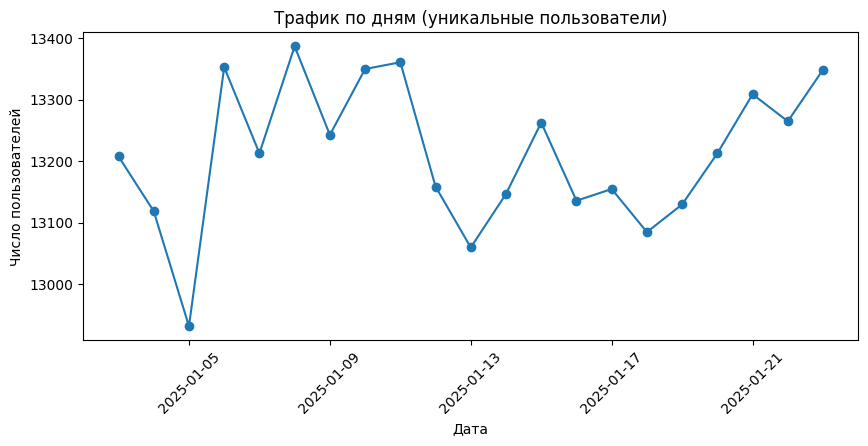

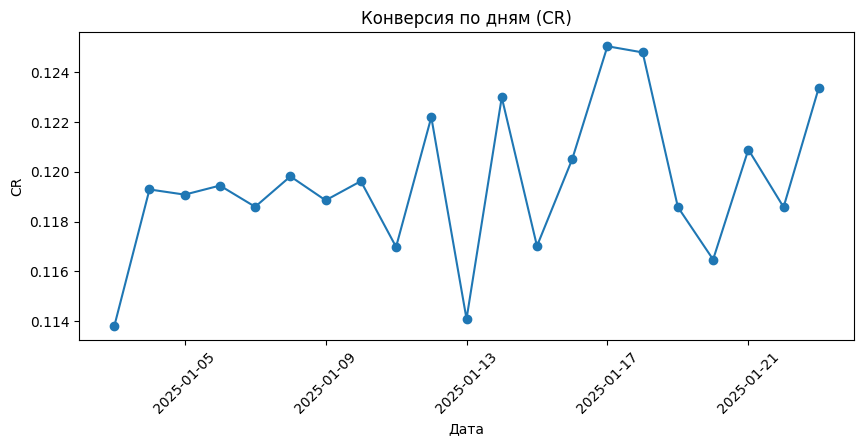

In [173]:
# находим минимальную и максимальную дату в отфильтрованных данных
start_date = df['visit_date'].min()
end_date = df['visit_date'].max()

# создаем "календарь" - таблицу со всеми датами
calendar = pd.DataFrame({
    "visit_date": pd.date_range(start=start_date, end=end_date)
})

# оставляем только компонент "дата" (без времени), чтобы тип совпадал с data['visit_date']
calendar["visit_date"] = calendar["visit_date"].dt.date

# агрегируем трафик по дням: users_total: сколько уникальных пользователей заходило в день
# conversions: сколько всего конверсий
daily = (
    df.groupby("visit_date")
        .agg(
            users_total=("user_id", "nunique"),
            conversions=("converted", "sum")
        )
        .reset_index()
)

daily["cr"] = daily["conversions"] / daily["users_total"]

# джойним календарь и наши данные
calendar_daily = calendar.merge(daily, on="visit_date", how="left")

print("\nДанные по дням:")
print(calendar_daily)

# Графики

# на всякий случай заполним NaN нулями перед графиками
plot_df = calendar_daily.copy()
plot_df[["users_total", "conversions", "cr"]] = \
    plot_df[["users_total", "conversions", "cr"]].fillna(0)

# приводим даты к datetime
plot_df["visit_date"] = pd.to_datetime(plot_df["visit_date"])

# график трафика по дням
plt.figure(figsize=(10, 4))
plt.plot(plot_df["visit_date"], plot_df["users_total"], marker="o")
plt.title("Трафик по дням (уникальные пользователи)")
plt.xlabel("Дата")
plt.ylabel("Число пользователей")
plt.xticks(rotation=45)
plt.show()

# график конверсии по дням
plt.figure(figsize=(10, 4))
plt.plot(plot_df["visit_date"], plot_df["cr"], marker="o")
plt.title("Конверсия по дням (CR)")
plt.xlabel("Дата")
plt.ylabel("CR")
plt.xticks(rotation=45)
plt.show()

**Вывод:**

Анализ распределения дневного трафика показал, что минимальное значение составляет 13 116 пользователей, а максимальное - 13 556 пользователей. Разница равна всего 440 пользователям, что составляет лишь 3,29% от среднего дневного трафика. Такой небольшой разброс говорит о том, что приток пользователей в течение всего периода эксперимента был стабильным, без выраженных всплесков или провалов.

По дневной конверсии картина аналогичная: минимум - 0,1137, максимум - 0,1248, разница - 0,0111, что соответствует 9,28% от среднего CR. Это тоже очень небольшой диапазон для дневных колебаний, что позволяет заключить, что конверсия практически не подвержена влиянию конкретных дат и ведёт себя равномерно.

# Анализ трафика по дням недели


Агрегация по дням недели:
   weekday  users_total  conversions  n_days  avg_users_per_day  cr_total
0        0        39626         4624       3       13208.666667  0.116691
1        1        39669         4793       3       13223.000000  0.120825
2        2        39915         4729       3       13305.000000  0.118477
3        3        39728         4804       3       13242.666667  0.120922
4        4        39713         4745       3       13237.666667  0.119482
5        5        39565         4761       3       13188.333333  0.120334
6        6        39221         4705       3       13073.666667  0.119961


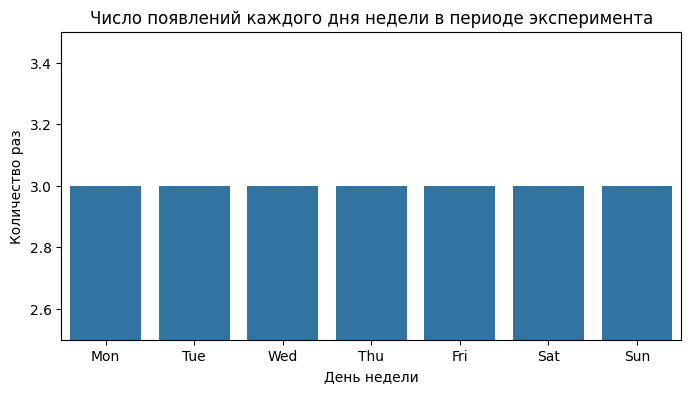

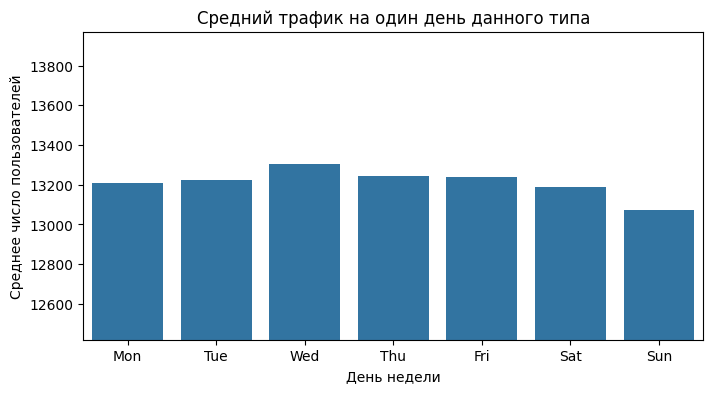

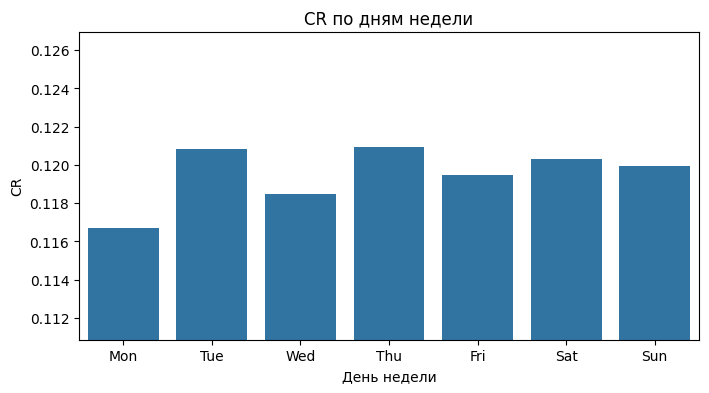


Агрегация по дням недели и группам:
    weekday      group  users_total  conversions  n_days  avg_users_per_day  \
0         0    control        19692         2281       3        6564.000000   
1         0  treatment        19934         2343       3        6644.666667   
2         1    control        19901         2479       3        6633.666667   
3         1  treatment        19768         2314       3        6589.333333   
4         2    control        19997         2390       3        6665.666667   
5         2  treatment        19918         2339       3        6639.333333   
6         3    control        19935         2440       3        6645.000000   
7         3  treatment        19793         2364       3        6597.666667   
8         4    control        19861         2314       3        6620.333333   
9         4  treatment        19852         2431       3        6617.333333   
10        5    control        19748         2406       3        6582.666667   
11        5  tr

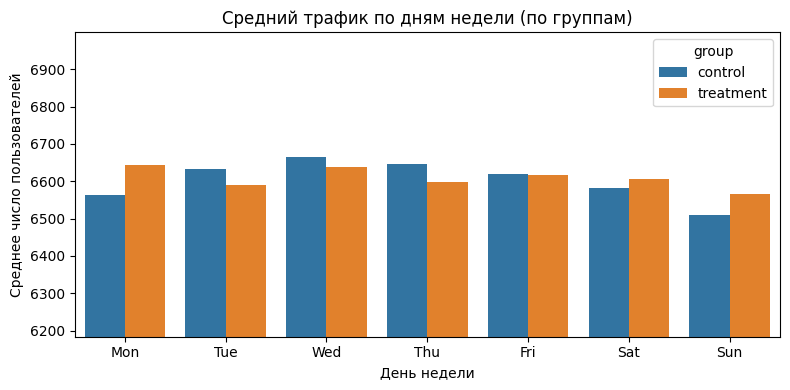

In [174]:
# добавляем номер дня недели для каждой даты
calendar_daily["weekday"] = pd.to_datetime(calendar_daily["visit_date"]).dt.dayofweek

# считаем, сколько раз каждый день недели встретился в нашем периоде
weekday_counts = (
    calendar_daily.groupby("weekday")["visit_date"]
        .count()
        .rename("n_days")
        .reset_index()
)

# суммарный трафик и суммарные конверсии по каждому дню недели
weekday_agg = (
    calendar_daily.groupby("weekday")
        .agg(
            users_total=("users_total", "sum"), # всего пользователей за все пн/вт...
            conversions=("conversions", "sum") # всего конверсий за все эти дни
        )
        .reset_index()
)

# добавляем это в наши данные
weekday_agg = weekday_agg.merge(weekday_counts, on="weekday", how="left")

# считаем средний трафик на один день данного типа
weekday_agg["avg_users_per_day"] = weekday_agg["users_total"] / weekday_agg["n_days"]
weekday_agg["cr_total"] = weekday_agg["conversions"] / weekday_agg["users_total"]

print("\nАгрегация по дням недели:")
print(weekday_agg)

# Графики

# подписи для дней недели нормальные вместо цифр 0-6
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plot_df = weekday_agg.copy()
plot_df["weekday_name"] = plot_df["weekday"].apply(lambda x: weekday_labels[x])

# 1. Сколько раз каждый день недели встречается в периоде
plt.figure(figsize=(8, 4))
ax1 = sns.barplot(data=plot_df, x="weekday_name", y="n_days")
plt.title("Число появлений каждого дня недели в периоде эксперимента")
plt.xlabel("День недели")
plt.ylabel("Количество раз")

# немного сжимаем ось Y, чтобы лучше была видна разница
ax1.set_ylim(plot_df["n_days"].min() - 0.5,
             plot_df["n_days"].max() + 0.5) # отступы от границ
plt.show()

# 2. Средний трафик на один такой день недели
plt.figure(figsize=(8, 4))
ax2 = sns.barplot(data=plot_df, x="weekday_name", y="avg_users_per_day")
plt.title("Средний трафик на один день данного типа")
plt.xlabel("День недели")
plt.ylabel("Среднее число пользователей")

# снова сжимаем ось Y, чтобы лучше была видна разница
ax2.set_ylim(plot_df["avg_users_per_day"].min() * 0.95,
             plot_df["avg_users_per_day"].max() * 1.05)
plt.show()

# 3. Общий CR по дням недели
plt.figure(figsize=(8, 4))
ax3 = sns.barplot(data=plot_df, x="weekday_name", y="cr_total")
plt.title("CR по дням недели")
plt.xlabel("День недели")
plt.ylabel("CR")

# снова сжимаем ось Y, чтобы лучше была видна разница
ax3.set_ylim(plot_df["cr_total"].min() * 0.95,
             plot_df["cr_total"].max() * 1.05)
plt.show()

# добавляем номер дня недели в основной датасет df
df["weekday"] = pd.to_datetime(df["visit_date"]).dt.dayofweek

# агрегируем по дням недели и группам
weekday_group = (
    df.groupby(["weekday", "group"])
        .agg(
            users_total=("user_id", "nunique"), # всего уникальных пользователей в такие дни
            conversions=("converted", "sum")  # всего конверсий в такие дни
        )
        .reset_index()
)

# добавляем число дней данного типа (n_days уже посчитан выше через weekday_counts)
weekday_group = weekday_group.merge(weekday_counts[["weekday", "n_days"]],
                                    on="weekday", how="left")

# средний трафик на один день данного типа и CR внутри группы
weekday_group["avg_users_per_day"] = weekday_group["users_total"] / weekday_group["n_days"]
weekday_group["cr_total"] = weekday_group["conversions"] / weekday_group["users_total"]

# нормальные подписи для дней недели
weekday_group["weekday_name"] = weekday_group["weekday"].apply(lambda x: weekday_labels[x])

print("\nАгрегация по дням недели и группам:")
print(weekday_group)

# Визуализации по группам

# 1. Средний трафик по дням недели по группам
plt.figure(figsize=(8, 4))
ax_g1 = sns.barplot(
    data=weekday_group,
    x="weekday_name",
    y="avg_users_per_day",
    hue="group"
)
plt.title("Средний трафик по дням недели (по группам)")
plt.xlabel("День недели")
plt.ylabel("Среднее число пользователей")

# чуть сжимаем ось Y
y_min = weekday_group["avg_users_per_day"].min()
y_max = weekday_group["avg_users_per_day"].max()
ax_g1.set_ylim(y_min * 0.95, y_max * 1.05)
plt.tight_layout()
plt.show()

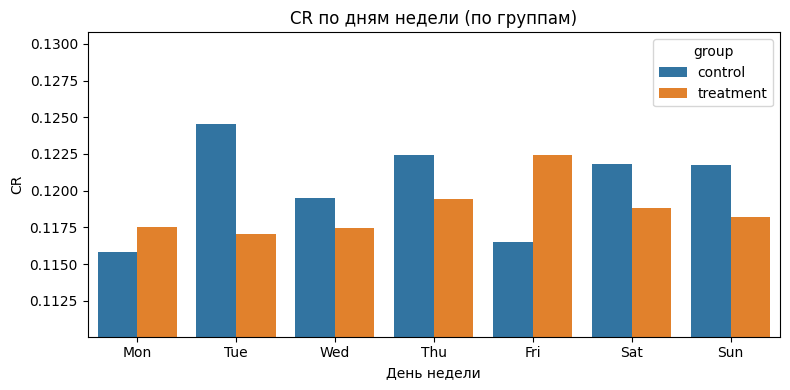


Разброс среднего трафика по дням недели внутри каждой группы:
       group          min          max         mean        diff  diff_pct
0    control  6509.000000  6665.666667  6602.904762  156.666667  2.372693
1  treatment  6564.666667  6644.666667  6608.380952   80.000000  1.210584

Разброс CR по дням недели внутри каждой группы:
       group       min       max      mean      diff  diff_pct
0    control  0.115834  0.124567  0.120341  0.008733  7.256657
1  treatment  0.117058  0.122456  0.118709  0.005398  4.547497


In [175]:
# 2. CR по дням недели по группам
plt.figure(figsize=(8, 4))
ax_g2 = sns.barplot(
    data=weekday_group,
    x="weekday_name",
    y="cr_total",
    hue="group"
)
plt.title("CR по дням недели (по группам)")
plt.xlabel("День недели")
plt.ylabel("CR")

y_min = weekday_group["cr_total"].min()
y_max = weekday_group["cr_total"].max()
ax_g2.set_ylim(y_min * 0.95, y_max * 1.05)
plt.tight_layout()
plt.show()

# Анализ разброса по группам

traffic_stats = (
    weekday_group.groupby("group")["avg_users_per_day"]
    .agg(["min", "max", "mean"])
    .reset_index()
)
traffic_stats["diff"] = traffic_stats["max"] - traffic_stats["min"]
traffic_stats["diff_pct"] = traffic_stats["diff"] / traffic_stats["mean"] * 100

cr_stats = (
    weekday_group.groupby("group")["cr_total"]
    .agg(["min", "max", "mean"])
    .reset_index()
)
cr_stats["diff"] = cr_stats["max"] - cr_stats["min"]
cr_stats["diff_pct"] = cr_stats["diff"] / cr_stats["mean"] * 100

print("\nРазброс среднего трафика по дням недели внутри каждой группы:")
print(traffic_stats)

print("\nРазброс CR по дням недели внутри каждой группы:")
print(cr_stats)

**Вывод:**

Теперь, когда мы убрали крайние дни, каждый день недели встречается ровно 3 раза, что обеспечивает полностью равномерное покрытие периода эксперимента. Разница между минимальным и максимальным средним дневным трафиком составляет:
13 239 - 13 471 пользователей
разброс: всего 232 пользователя (примерно 1.73% от среднего трафика)
Такой разброс слишком мал, чтобы объяснять какие-то значимые сдвиги в поведении пользователей. Никаких аномальных провалов или всплесков не наблюдается.

Графики показывают:
Линии трафика по группам практически совпадают (с минимальными отклонениями). Линии CR по группам также идут рядом и не имеют резких расхождений. Нет ни одного дня недели, когда одна группа сильно превалирует над другой. Это означает, что день недели не является фактором, способным повлиять на результаты эксперимента.

# Анализ влияния времени на результаты тестирования

Код проверяет влияют ли всплески конверсии в определенные часы на результаты тестирования

In [176]:
# Добавляем колонку с часом
df['hour'] = df['timestamp'].dt.hour

# Конверсия по часам и группам
hourly_conv = df.groupby(['hour', 'group'])['converted'].mean().unstack()

# Среднее и стандартное отклонение по группам
mean_control = hourly_conv['control'].mean()
std_control = hourly_conv['control'].std()
control_2std = 2 * std_control

mean_treat = hourly_conv['treatment'].mean()
std_treat = hourly_conv['treatment'].std()
treat_2std = 2 * std_treat

print(f"Control: среднее = {round(mean_control, 4)}, 2*std = {round(control_2std, 4)}")
print(f"Treatment: среднее = {round(mean_treat, 4)}, 2*std = {round(treat_2std, 4)}")

# Список для отклонений по всем часам и группам
diff_all = []

# Подсчет конверсии и отклонения
for hour in hourly_conv.index:
    conv_c = hourly_conv.loc[hour, 'control']
    conv_t = hourly_conv.loc[hour, 'treatment']

    diff_c = conv_c - mean_control
    diff_t = conv_t - mean_treat

    diff_all.append((hour, 'control', diff_c, conv_c))
    diff_all.append((hour, 'treatment', diff_t, conv_t))

# Топ-5 общих всплесков и спадов по абсолютному отклонению
top5_up = sorted(diff_all, key=lambda x: x[2], reverse=True)[:5]
top5_down = sorted(diff_all, key=lambda x: x[2])[:5]

print("\nТоп-5 часов с наибольшим всплеском (обе группы):")
for hour, group, diff, conv in top5_up:
    print(f"Час {hour}, группа {group}: конверсия = {round(conv, 4)}, отклонение = {round(diff, 4)} (всплеск)")

print("\nТоп-5 часов с наибольшим спадом (обе группы):")
for hour, group, diff, conv in top5_down:
    print(f"Час {hour}, группа {group}: конверсия = {round(conv, 4)}, отклонение = {round(diff, 4)} (спад)")

# Определяем аномальные часы (>2 std отклонений)
anomaly_hours_control = hourly_conv[abs(hourly_conv['control'] - mean_control) > control_2std].index.tolist()
anomaly_hours_treat = hourly_conv[abs(hourly_conv['treatment'] - mean_treat) > treat_2std].index.tolist()
bad_hours = list(set(anomaly_hours_control + anomaly_hours_treat))
print("\nАномальные часы (потенциально шумные):", bad_hours)

# Z-тест на всех данных
s_c = df[df['group']=='control']['converted'].sum()
s_t = df[df['group']=='treatment']['converted'].sum()
n_c = len(df[df['group']=='control'])
n_t = len(df[df['group']=='treatment'])
z_all, p_all = proportions_ztest([s_c, s_t], [n_c, n_t])
print("\nZ-тест на всех данных: Z =", round(z_all, 4), "p =", round(p_all, 5))

# Z-тест на данных без аномальных часов
clean_by_hours = df[~df['hour'].isin(bad_hours)]

s_c2 = clean_by_hours[clean_by_hours['group']=='control']['converted'].sum()
s_t2 = clean_by_hours[clean_by_hours['group']=='treatment']['converted'].sum()
n_c2 = len(clean_by_hours[clean_by_hours['group']=='control'])
n_t2 = len(clean_by_hours[clean_by_hours['group']=='treatment'])
z_clean, p_clean = proportions_ztest([s_c2, s_t2], [n_c2, n_t2])
print("Z-тест без аномальных часов: Z =", round(z_clean, 4), "p =", round(p_clean, 5))

Control: среднее = 0.1204, 2*std = 0.0096
Treatment: среднее = 0.1187, 2*std = 0.0105

Топ-5 часов с наибольшим всплеском (обе группы):
Час 18, группа treatment: конверсия = 0.1273, отклонение = 0.0086 (всплеск)
Час 11, группа control: конверсия = 0.1288, отклонение = 0.0085 (всплеск)
Час 23, группа control: конверсия = 0.1279, отклонение = 0.0075 (всплеск)
Час 9, группа treatment: конверсия = 0.126, отклонение = 0.0073 (всплеск)
Час 6, группа control: конверсия = 0.1271, отклонение = 0.0067 (всплеск)

Топ-5 часов с наибольшим спадом (обе группы):
Час 4, группа treatment: конверсия = 0.1072, отклонение = -0.0115 (спад)
Час 1, группа treatment: конверсия = 0.1096, отклонение = -0.0091 (спад)
Час 19, группа control: конверсия = 0.112, отклонение = -0.0084 (спад)
Час 3, группа control: конверсия = 0.1137, отклонение = -0.0067 (спад)
Час 2, группа control: конверсия = 0.1139, отклонение = -0.0065 (спад)

Аномальные часы (потенциально шумные): [4]

Z-тест на всех данных: Z = 1.327 p = 0.184

**Средняя конверсия и стандартные отклонения:**

    Control: средняя конверсия = 0.1204, 2*стандартных отклонения = 0.0096,
    Treatment: средняя конверсия = 0.1187, 2*стандартных отклонения = 0.0105

Средние значения конверсии для обеих групп близки, что говорит о стабильности поведения пользователей в целом.

Для каждой группы была рассчитана конверсия по часам и отклонение от среднего значения.

Аномальные (потенциально шумные) часы: **4**. В это время аномально низкая конверсия (ночная активность минимальна, мало пользователей).

Максимальная конверсия (пиковая активность): 6, 9, 11, 18, 23 часов. Утро (6–11) — пользователи проверяют почту, социальные сети и образовательные сайты перед работой или учёбой. Вечер (18, 23) — пользователи возвращаются с работы/учёбы и активно пользуются интернетом. Также возможен эффект маркетинговых рассылок или push-уведомлений.

Минимальная конверсия (минимальная активность): 1, 2, 3, 4, 19 часов. Ночь (1-4) — большинство пользователей спят, посещаемость минимальна, конверсии падают. В 19 часов пользователи могут быть заняты домашними делами. Малый объём пользователей ночью усиливает влияние случайных колебаний на конверсию.

ТОП-5 часов показывает сильные отклонения, но это не значит, что они аномальные. Аномальные часы выделяются отдельно (>2 стандартных отклонений).

**Результаты Z-теста:**

	На всех данных: Z = 1.327, p = 0.18451 - нет статистически значимой разницы между группами.
	Без аномальных часов: Z = 0.8611, p = 0.38917 - исключение шумных часов также не выявляет значимой разницы.

**Вывод**

Даже после исключения аномальных часов результат эксперимента остаётся неизменным — нет статистически значимых различий в конверсии между группами. Аномальные часы показывают временные колебания конверсии, но они не оказывают влияния на общую конверсию и не изменяют общий вывод эксперимента.

# Гипотезы

На основании выбранной метрики наша команда выдвигает следующие гипотезы:

**Нулевая гипотеза (H₀)** - конверсия в группе treatment не отличается от конверсии в группе control.

**Альтернативная гипотеза (H₁)** - конверсия в группе treatment отличается от конверсии в группе control.